<a href="https://colab.research.google.com/github/AnyasorG/credit_fraud_risk_prediction/blob/main/credit_card_fraud_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Development of Credit Card Fraud Web app using Machine Learning
Dataset source: https://www.kaggle.com/datasets/rafeulopes/credit-fraud/code

In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn tensorflow keras-tuner

In [2]:
%matplotlib inline
# Import necessary libraries

# Initial Imports
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import keras_tuner as kt

In [3]:
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.5.1'
spark_version = 'spark-3.5.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 114 kB in 2s (60.7 kB/s)
Reading package lists... Done


In [4]:
!pip install -q kaggle
from google.colab import drive
import shutil
import os

# Mount Google Drive
drive.mount('/content/drive')

# Set paths
kaggle_token_path = '/content/drive/My Drive/kaggle.json'
kaggle_dir = '/root/.kaggle/'

# Check if kaggle directory exists, if not, create it
if not os.path.exists(kaggle_dir):
    os.makedirs(kaggle_dir)

# Copy kaggle.json from Google Drive to appropriate directory
if os.path.exists(kaggle_token_path):
    shutil.copy(kaggle_token_path, kaggle_dir)
    os.chmod(kaggle_dir + 'kaggle.json', 600)

# Download dataset from Kaggle
!kaggle datasets download -d kelvinkelue/credit-card-fraud-prediction

# Unzip the dataset
!unzip -o credit-card-fraud-prediction.zip


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
credit-card-fraud-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  credit-card-fraud-prediction.zip
  inflating: fraud test.csv          


In [5]:
# Initialize Spark session
from pyspark.sql import SparkSession
import os

# Set up Spark session
spark = SparkSession.builder \
    .appName("Kaggle_Dataset") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "2g") \
    .getOrCreate()

# Set the path to the dataset
dataset_path = 'fraud test.csv'  # Assuming the dataset is in the current directory

# Load dataset into Spark DataFrame
df = spark.read.csv(dataset_path, header=True, inferSchema=True)

# Show the first few rows of the DataFrame
df.show()


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


+---+---------------------+----------+--------------------+--------------+------+---------+--------+------+--------------------+-------------+-----+-----+-------+---------+--------+--------------------+----------+--------------------+----------+---------+-----------+--------+
|_c0|trans_date_trans_time|    cc_num|            merchant|      category|   amt|    first|    last|gender|              street|         city|state|  zip|    lat|     long|city_pop|                 job|       dob|           trans_num| unix_time|merch_lat| merch_long|is_fraud|
+---+---------------------+----------+--------------------+--------------+------+---------+--------+------+--------------------+-------------+-----+-----+-------+---------+--------+--------------------+----------+--------------------+----------+---------+-----------+--------+
|  0|     21/06/2020 12:14|2.29116E15|fraud_Kirlin and ...| personal_care|  2.86|     Jeff| Elliott|     M|   351 Darlene Green|     Columbia|   SC|29209|33.9659| -80.93

In [6]:
# Show schema to confirm date type
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- trans_date_trans_time: string (nullable = true)
 |-- cc_num: double (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: double (nullable = true)
 |-- first: string (nullable = true)
 |-- last: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- city_pop: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: string (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- unix_time: integer (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- is_fraud: integer (nullable = true)



In [7]:
# Convert PySpark DataFrame to Pandas DataFrame with correct date formats
df = df.toPandas()

# Convert date columns to correct date format
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'], errors='coerce', dayfirst=True)
df['dob'] = pd.to_datetime(df['dob'], errors='coerce', dayfirst=True)

# Remove leading and trailing spaces from all column names
df.columns = df.columns.str.strip()

# Set the option to display all columns
pd.options.display.max_columns = None

# Show the first few rows of the DataFrame
df.head()


,_c0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:00,2.291160e+15,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:00,3.573030e+15,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:00,3.598220e+15,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,NY,11710,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:00,3.591920e+15,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,FL,32780,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:00,3.526830e+15,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,MI,49632,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [8]:
df.columns

Index(['_c0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud'],
      dtype='object')

In [9]:
# List of irrelevant column names to drop
columns_to_drop = ['_c0', 'cc_num', 'first', 'last', 'street', 'city', 'state', 'zip', 'job', 'dob', 'trans_num', 'unix_time', 'gender', 'trans_date_trans_time']

# Drop the columns
df = df.drop(columns=columns_to_drop)

# Show the first few rows of the DataFrame
df.head()


,merchant,category,amt,lat,long,city_pop,merch_lat,merch_long,is_fraud
0,fraud_Kirlin and Sons,personal_care,2.86,33.9659,-80.9355,333497,33.986391,-81.200714,0
1,fraud_Sporer-Keebler,personal_care,29.84,40.3207,-110.4360,302,39.450498,-109.960431,0
2,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,40.6729,-73.5365,34496,40.495810,-74.196111,0
3,fraud_Haley Group,misc_pos,60.05,28.5697,-80.8191,54767,28.812398,-80.883061,0
4,fraud_Johnston-Casper,travel,3.19,44.2529,-85.0170,1126,44.959148,-85.884734,0


In [10]:
df.columns


Index(['merchant', 'category', 'amt', 'lat', 'long', 'city_pop', 'merch_lat',
       'merch_long', 'is_fraud'],
      dtype='object')

In [11]:
df = df.rename(columns={
    'merchant': 'Merchant',
    'category': 'Transaction Category',
    'amt': 'Transaction Amount',
    'lat': 'Cardholder Latitude',
    'long': 'Cardholder Longitude',
    'city_pop': 'City Population',
    'merch_lat': 'Merchant Latitude',
    'merch_long': 'Merchant Longitude',
    'is_fraud': 'Fraudulent Transaction'
})
df.head()

,Merchant,Transaction Category,Transaction Amount,Cardholder Latitude,Cardholder Longitude,City Population,Merchant Latitude,Merchant Longitude,Fraudulent Transaction
0,fraud_Kirlin and Sons,personal_care,2.86,33.9659,-80.9355,333497,33.986391,-81.200714,0
1,fraud_Sporer-Keebler,personal_care,29.84,40.3207,-110.4360,302,39.450498,-109.960431,0
2,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,40.6729,-73.5365,34496,40.495810,-74.196111,0
3,fraud_Haley Group,misc_pos,60.05,28.5697,-80.8191,54767,28.812398,-80.883061,0
4,fraud_Johnston-Casper,travel,3.19,44.2529,-85.0170,1126,44.959148,-85.884734,0


In [12]:
# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())



Missing values:
Merchant                  0
Transaction Category      0
Transaction Amount        0
Cardholder Latitude       0
Cardholder Longitude      0
City Population           0
Merchant Latitude         0
Merchant Longitude        0
Fraudulent Transaction    0
dtype: int64


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Merchant                555719 non-null  object 
 1   Transaction Category    555719 non-null  object 
 2   Transaction Amount      555719 non-null  float64
 3   Cardholder Latitude     555719 non-null  float64
 4   Cardholder Longitude    555719 non-null  float64
 5   City Population         555719 non-null  int32  
 6   Merchant Latitude       555719 non-null  float64
 7   Merchant Longitude      555719 non-null  float64
 8   Fraudulent Transaction  555719 non-null  int32  
dtypes: float64(5), int32(2), object(2)
memory usage: 33.9+ MB


In [14]:
df.columns

Index(['Merchant', 'Transaction Category', 'Transaction Amount',
       'Cardholder Latitude', 'Cardholder Longitude', 'City Population',
       'Merchant Latitude', 'Merchant Longitude', 'Fraudulent Transaction'],
      dtype='object')

In [15]:
# Generate summary statistics for numerical columns
df.describe().round()

,Transaction Amount,Cardholder Latitude,Cardholder Longitude,City Population,Merchant Latitude,Merchant Longitude,Fraudulent Transaction
count,555719.0,555719.0,555719.0,555719.0,555719.0,555719.0,555719.0
mean,69.0,39.0,-90.0,88222.0,39.0,-90.0,0.0
std,157.0,5.0,14.0,300391.0,5.0,14.0,0.0
min,1.0,20.0,-166.0,23.0,19.0,-167.0,0.0
25%,10.0,35.0,-97.0,741.0,35.0,-97.0,0.0
50%,47.0,39.0,-87.0,2408.0,39.0,-87.0,0.0
75%,83.0,42.0,-80.0,19685.0,42.0,-80.0,0.0
max,22768.0,66.0,-68.0,2906700.0,67.0,-67.0,1.0


Compute Correlation Matrix

In [16]:
# Select only numerical columns for correlation calculation
numerical_columns = df.select_dtypes(include=['float64', 'int32']).columns

# Compute correlation matrix
correlation_matrix = df[numerical_columns].corr()

# Print the correlation matrix
correlation_matrix.round(2)


,Transaction Amount,Cardholder Latitude,Cardholder Longitude,City Population,Merchant Latitude,Merchant Longitude,Fraudulent Transaction
Transaction Amount,1.00,0.00,-0.00,0.00,0.00,-0.00,0.18
Cardholder Latitude,0.00,1.00,-0.01,-0.15,0.99,-0.01,0.01
Cardholder Longitude,-0.00,-0.01,1.00,-0.05,-0.01,1.00,-0.00
City Population,0.00,-0.15,-0.05,1.00,-0.15,-0.05,-0.00
Merchant Latitude,0.00,0.99,-0.01,-0.15,1.00,-0.01,0.01
Merchant Longitude,-0.00,-0.01,1.00,-0.05,-0.01,1.00,-0.00
Fraudulent Transaction,0.18,0.01,-0.00,-0.00,0.01,-0.00,1.00


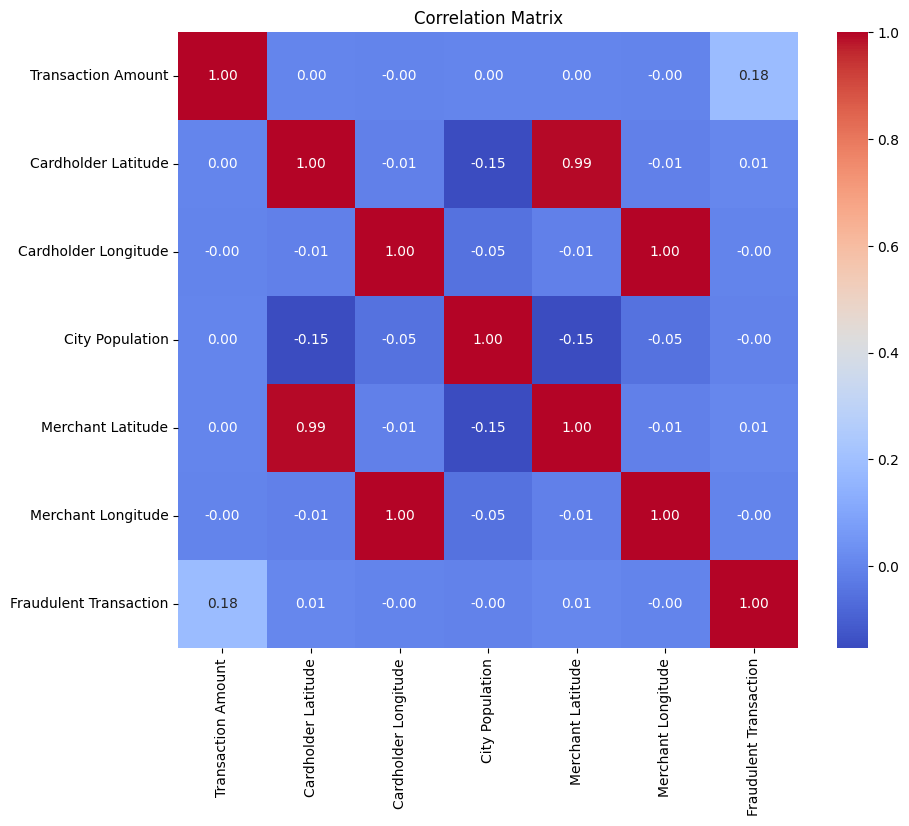

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numerical columns for correlation calculation
numerical_columns = df.select_dtypes(include=['float64', 'int32']).columns

# Compute correlation matrix
correlation_matrix = df[numerical_columns].corr()

# Create a heatmap plot
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


In [18]:
# Check the data types of all columns
print(df.dtypes)


Merchant                   object
Transaction Category       object
Transaction Amount        float64
Cardholder Latitude       float64
Cardholder Longitude      float64
City Population             int32
Merchant Latitude         float64
Merchant Longitude        float64
Fraudulent Transaction      int32
dtype: object


In [19]:
df.head()

,Merchant,Transaction Category,Transaction Amount,Cardholder Latitude,Cardholder Longitude,City Population,Merchant Latitude,Merchant Longitude,Fraudulent Transaction
0,fraud_Kirlin and Sons,personal_care,2.86,33.9659,-80.9355,333497,33.986391,-81.200714,0
1,fraud_Sporer-Keebler,personal_care,29.84,40.3207,-110.4360,302,39.450498,-109.960431,0
2,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,40.6729,-73.5365,34496,40.495810,-74.196111,0
3,fraud_Haley Group,misc_pos,60.05,28.5697,-80.8191,54767,28.812398,-80.883061,0
4,fraud_Johnston-Casper,travel,3.19,44.2529,-85.0170,1126,44.959148,-85.884734,0


In [20]:
# Create a dictionary to map each unique Transaction Category to a numerical code
category_map = {
    'entertainment': 0,
    'food_dining': 1,
    'gas_transport': 2,
    'grocery_net': 3,
    'grocery_pos': 4,
    'health_fitness': 5,
    'home': 6,
    'kids_pets': 7,
    'misc_net': 8,
    'misc_pos': 9,
    'personal_care': 10,
    'shopping_net': 11,
    'shopping_pos': 12,
    'travel': 13,
}

# Map the Transaction Category column using the dictionary
df['Transaction Category'] = df['Transaction Category'].map(category_map)

# Display the DataFrame with mapped Transaction Category values
df.head()


,Merchant,Transaction Category,Transaction Amount,Cardholder Latitude,Cardholder Longitude,City Population,Merchant Latitude,Merchant Longitude,Fraudulent Transaction
0,fraud_Kirlin and Sons,10,2.86,33.9659,-80.9355,333497,33.986391,-81.200714,0
1,fraud_Sporer-Keebler,10,29.84,40.3207,-110.4360,302,39.450498,-109.960431,0
2,"fraud_Swaniawski, Nitzsche and Welch",5,41.28,40.6729,-73.5365,34496,40.495810,-74.196111,0
3,fraud_Haley Group,9,60.05,28.5697,-80.8191,54767,28.812398,-80.883061,0
4,fraud_Johnston-Casper,13,3.19,44.2529,-85.0170,1126,44.959148,-85.884734,0


In [21]:
# Identify unique values in the 'Merchant' column
unique_merchants = df['Merchant'].nunique()

# Display unique values
print(unique_merchants)


693


In [22]:
# Strip leading and trailing whitespace from the 'Merchant' column
df['Merchant'] = df['Merchant'].str.strip()

# Use factorize to map unique Merchant values to numerical codes
df['Merchant'] = pd.factorize(df['Merchant'])[0]

# Display the DataFrame with mapped Merchant values
df.head()


,Merchant,Transaction Category,Transaction Amount,Cardholder Latitude,Cardholder Longitude,City Population,Merchant Latitude,Merchant Longitude,Fraudulent Transaction
0,0,10,2.86,33.9659,-80.9355,333497,33.986391,-81.200714,0
1,1,10,29.84,40.3207,-110.4360,302,39.450498,-109.960431,0
2,2,5,41.28,40.6729,-73.5365,34496,40.495810,-74.196111,0
3,3,9,60.05,28.5697,-80.8191,54767,28.812398,-80.883061,0
4,4,13,3.19,44.2529,-85.0170,1126,44.959148,-85.884734,0


In [23]:
# Define features (X) and target variable (y)
X = df.drop('Fraudulent Transaction', axis=1)  # Features are all columns except 'Fraudulent Transaction'
y = df['Fraudulent Transaction']  # Target variable is 'Fraudulent Transaction' column

# Display the shapes of X and y
print("Shape of features (X):", X.shape)
print("Shape of target variable (y):", y.shape)


Shape of features (X): (555719, 8)
Shape of target variable (y): (555719,)


In [24]:
# Display the processed DataFrame
print("\nProcessed DataFrame:")
X.head()


Processed DataFrame:


,Merchant,Transaction Category,Transaction Amount,Cardholder Latitude,Cardholder Longitude,City Population,Merchant Latitude,Merchant Longitude
0,0,10,2.86,33.9659,-80.9355,333497,33.986391,-81.200714
1,1,10,29.84,40.3207,-110.4360,302,39.450498,-109.960431
2,2,5,41.28,40.6729,-73.5365,34496,40.495810,-74.196111
3,3,9,60.05,28.5697,-80.8191,54767,28.812398,-80.883061
4,4,13,3.19,44.2529,-85.0170,1126,44.959148,-85.884734


In [25]:
print("\nTarget variable:")
y[:5]


Target variable:


0    0
1    0
2    0
3    0
4    0
Name: Fraudulent Transaction, dtype: int32

# Training and testing of datasets

In [26]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Create StandardScaler instance
scaler = StandardScaler()

# Fit StandardScaler
X_scaler = scaler.fit(X_train_balanced)

# Scale data
X_train_scaled = X_scaler.transform(X_train_balanced)
X_test_scaled = X_scaler.transform(X_test)

# Logistic Regression Model

In [27]:
# Create the logistic regression instance
logistic_model = LogisticRegression(solver='lbfgs', max_iter=200, random_state=1)

# Fit the model
logistic_model.fit(X_train_scaled, y_train_balanced)

# Make predictions
logistic_predictions = logistic_model.predict(X_test_scaled)

# Calculate confusion matrix
cm = confusion_matrix(y_test, logistic_predictions)
cm_df = pd.DataFrame(cm, index=["Not Fraudulent", "Fraudulent"], columns=["Predicted Not Fraudulent", "Predicted Fraudulent"])

# Calculate accuracy score
acc_score = accuracy_score(y_test, logistic_predictions)

# Displaying results
print("Confusion Matrix:")
display(cm_df)
print("-------------------------------------------")
print(f"Accuracy Score: {acc_score}")
print("-------------------------------------------")
print("Classification Report:")
print(classification_report(y_test, logistic_predictions, target_names=["Not Fraudulent", "Fraudulent"]))


Confusion Matrix:


,Predicted Not Fraudulent,Predicted Fraudulent
Not Fraudulent,104808,5910
Fraudulent,93,333


-------------------------------------------
Accuracy Score: 0.9459889872597711
-------------------------------------------
Classification Report:
                precision    recall  f1-score   support

Not Fraudulent       1.00      0.95      0.97    110718
    Fraudulent       0.05      0.78      0.10       426

      accuracy                           0.95    111144
     macro avg       0.53      0.86      0.54    111144
  weighted avg       1.00      0.95      0.97    111144



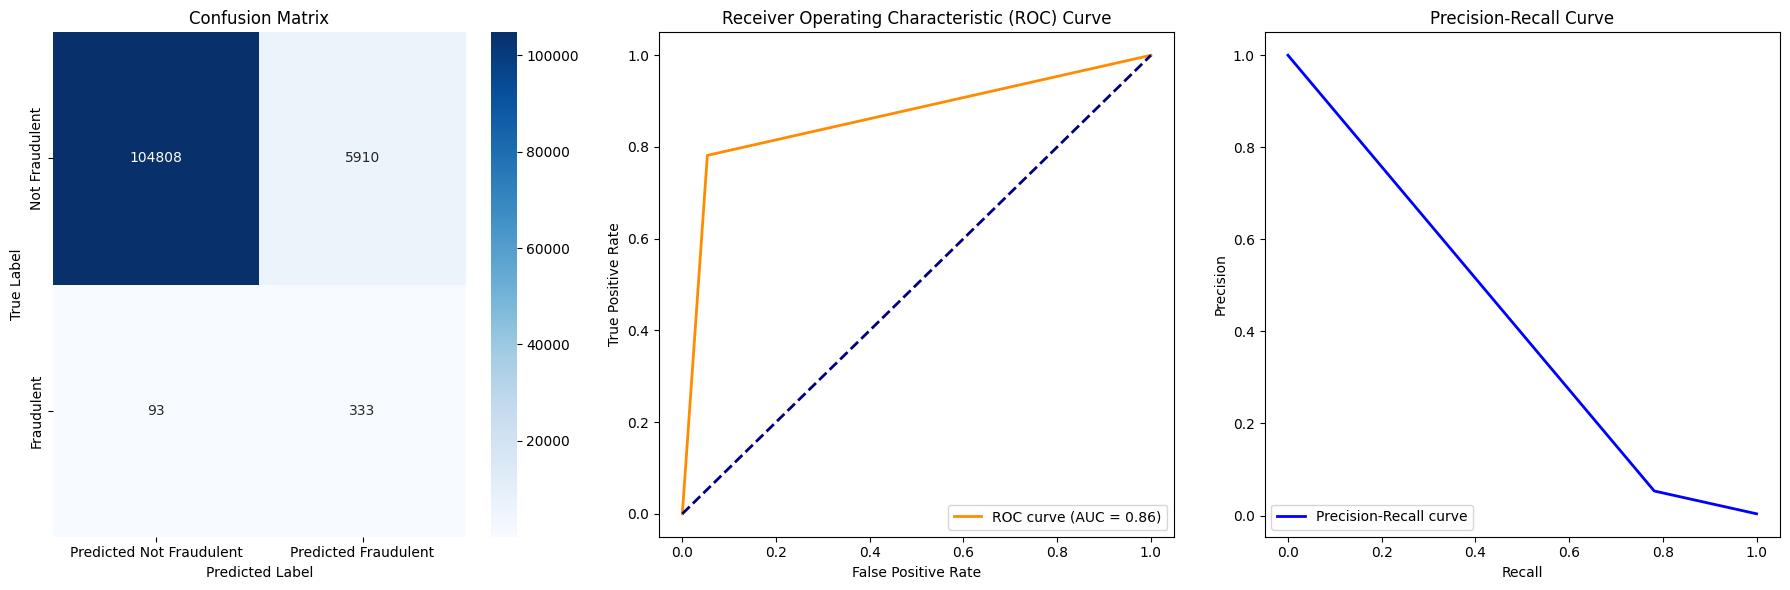

In [28]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Plot confusion matrix
plt.figure(figsize=(18, 6))

# Confusion Matrix
plt.subplot(1, 3, 1)
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# ROC curve
plt.subplot(1, 3, 2)
fpr, tpr, _ = roc_curve(y_test, logistic_predictions)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Precision-recall curve
plt.subplot(1, 3, 3)
precision, recall, _ = precision_recall_curve(y_test, logistic_predictions)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()


# Random Forest Model

In [29]:
from imblearn.over_sampling import SMOTE

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE to balance the classes in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

# Fit the model
rf_model.fit(X_train_resampled, y_train_resampled)

# Make predictions
predictions = rf_model.predict(X_test_scaled)

# Calculate accuracy score
acc_score = accuracy_score(y_test, predictions)

# Display results
print("Accuracy Score:", acc_score)

# Calculate confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm, index=["Not Fraudulent", "Fraudulent"], columns=["Predicted Not Fraudulent", "Predicted Fraudulent"])

# Display confusion matrix
print("Confusion Matrix:")
print(cm_df)

# Display classification report
print("-------------------------------------------")
print("Classification Report:")
print(classification_report(y_test, predictions, target_names=["Not Fraudulent", "Fraudulent"]))


Accuracy Score: 0.9963070931004423
Confusion Matrix:
                Predicted Not Fraudulent  Predicted Fraudulent
Not Fraudulent                    497264                   937
Fraudulent                           910                  1037
-------------------------------------------
Classification Report:
                precision    recall  f1-score   support

Not Fraudulent       1.00      1.00      1.00    498201
    Fraudulent       0.53      0.53      0.53      1947

      accuracy                           1.00    500148
     macro avg       0.76      0.77      0.76    500148
  weighted avg       1.00      1.00      1.00    500148



# Feature Importances

In [30]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_
# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.6141288808917241, 'Transaction Amount'),
 (0.11203081030967744, 'Transaction Category'),
 (0.0752811250664881, 'City Population'),
 (0.06455733050290574, 'Merchant'),
 (0.037894359011008356, 'Cardholder Latitude'),
 (0.03412550588311156, 'Cardholder Longitude'),
 (0.032868235779275806, 'Merchant Latitude'),
 (0.029113752555808857, 'Merchant Longitude')]

<Axes: title={'center': 'Feature Importances'}, ylabel='1'>

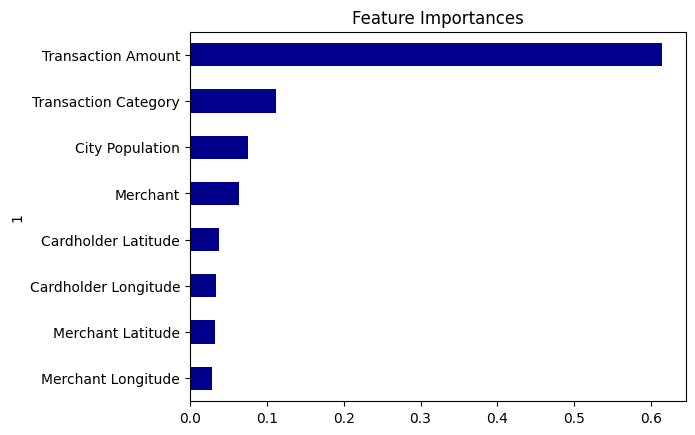

In [31]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='darkblue', title= 'Feature Importances', legend=False)